In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

In [133]:
#DEFINING KEY PARAMETERS

#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
#ANY PARAMETERS THAT WANT TO BE MODIFIED SHOULD BE MODIFIED HERE
#length of matrix
L = 40
#number of neighbors for happines
k = 3
#number of epochs
N = 20
#ratio of "red" and "blue" cells
ratio_RB = 0.88
#Relocation policy (OPTIONS: random, socialNetwork, custom1, custom2, custom3, custom4)
relocPolicy = "socialNetwork"
#number of tries agents should go through in random relocation policy (q)
q = 100
#number of friends each agent has in the socialNetwork relocation policy (n)
friend_num = 2
#size of friend neighborhood to check (p)
p = 3

#------------------------------------------------------------------------------
#------------------------------------------------------------------------------


# Creating a 40x40 array filled with "empty" strings
matrix = np.full((L, L), "empty", dtype=object)

# Modify the matrix within the chosen cells with "red" and "blue"
for i in range(int((ratio_RB*L**2)/2)):
  #Get a random coordinate to replace with either red or blue
  red_x = np.random.randint(0, L)
  red_y = np.random.randint(0, L)
  blue_x = np.random.randint(0, L)
  blue_y = np.random.randint(0, L)

  #keep searching for a coordinate space that's empty to place a new agent
  while (matrix[red_x][red_y] != "empty"):
    red_x = np.random.randint(0, L)
    red_y = np.random.randint(0, L)

  while(matrix[blue_x][blue_y] != "empty"):
    blue_x = np.random.randint(0, L)
    blue_y = np.random.randint(0, L)


  #add the correct agent color to that coordinate
  matrix[red_x][red_y] = "red"

  matrix[blue_x][blue_y] = "blue"

# Convert the matrix NumPy array to a pandas DataFrame
df = pd.DataFrame(matrix)

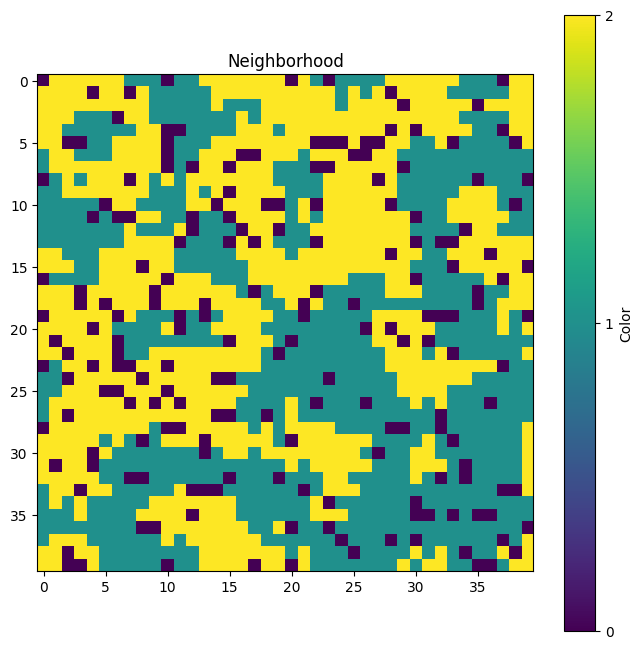

None

In [113]:
print_matrix(df) #if this function call does not work it's because the function is defined later in this code

In [115]:
#code to count number of reds, blues, and empty spaces, mostly useful for debugging purposes
num_red = 0
num_blue = 0
num_none = 0

for i in range(L):
  for j in range(L):
    if (df[i][j] == "red"):
      num_red = num_red + 1
    elif (df[i][j] == "blue"):
      num_blue = num_blue + 1
    else:
      num_none = num_none + 1


print("red: " + str(num_red))
print("blue: " + str(num_blue))
print("empty: " + str(num_none))


red: 703
blue: 704
empty: 193


In [116]:
#function to evaluate if a specific agent is happy in their current neighborhood
def is_happy(df, coords, agent_color):

  #extracting the row and column values from the coordinate array
  row = coords[0]
  col = coords[1]

  #creating varaible to keep track of how many neighbors are of the same color as agent
  same_neighbors = 0

  #calculating indexes of neighbors, making sure to loop back to other side of
  #matrix to avoid border conditions
  neighbors_indices = [
        ((row-1) % df.shape[1], (col-1) % df.shape[1]),
        ((row-1)  % df.shape[1], col),
        ((row-1)  % df.shape[1], (col+1) % df.shape[1]),
        (row, (col-1)  % df.shape[1] ),
        (row, (col+1) % df.shape[1]),
        ((row+1) % df.shape[0], (col-1)% df.shape[1]),
        ((row+1) % df.shape[0], col),
        ((row+1) % df.shape[0], (col+1) % df.shape[1])
    ]

  #check every neighbor index to see if it matches color with agent
  for index in neighbors_indices:

    #print("the neighbor at " + str(index) + " is " + df[index[1]][index[0]])

    if (df[index[1]][index[0]] == agent_color):
      #if the current neighbor is the same color, increase the counter
      same_neighbors = same_neighbors + 1

  #if the number of neighbors with the same color are bigger than the parameter k,
  #then return that the agent is happy, otherwise return False
  if(same_neighbors >= k):
    return True
  else:
    return False

In [117]:
#Function to calculate fractional happines of a spot for an agent
def happiness_functon(df, coords, agent_color):

  #extracting the row and column values from the coordinate array
  row = coords[0]
  col = coords[1]

  #creating varaible to keep track of how many neighbors are of the same color as agent
  same_neighbors = 0

  #calculating indexes of neighbors, making sure to loop back to other side of
  #matrix to avoid border conditions
  neighbors_indices = [
        ((row-1) % df.shape[1], (col-1) % df.shape[1]),
        ((row-1)  % df.shape[1], col),
        ((row-1)  % df.shape[1], (col+1) % df.shape[1]),
        (row, (col-1)  % df.shape[1] ),
        (row, (col+1) % df.shape[1]),
        ((row+1) % df.shape[0], (col-1)% df.shape[1]),
        ((row+1) % df.shape[0], col),
        ((row+1) % df.shape[0], (col+1) % df.shape[1])
    ]

  #check every neighbor index to see if it matches color with agent
  for index in neighbors_indices:

    if (df[index[1]][index[0]] == agent_color):
      #if the current neighbor is the same color, increase the counter
      same_neighbors = same_neighbors + 1

  #return a percentage based on k that tells you how close you are to the agent
  #being happy, with the max percentage being 1
  if (same_neighbors > k):
    return 1
  else:
    return(same_neighbors/k)

In [9]:
#function to collect a list of all coordinates with empty spaces
def collect_empty_spaces(matrix):

  #initialize empty list
  empty_coords = []

  #iterate through dataframe and add the coordiante to the list if the location is empty
  for i in range(matrix.shape[0]):
    for  j in range(matrix.shape[1]):
      if matrix[i, j] == "empty":
        empty_coords.append((i,j))

  return empty_coords

In [125]:
#random move policy
def random_move(df, empty_list, moving_agent):

  #getting the agent's color
  agent_color =  df[moving_agent[0]][moving_agent[1]]

  #choosing one of the empty spaces at random
  chosen_space = np.random.randint(0, len(empty_list))

  #variable to keep track of the tries to find a good spot
  num_tries = 0

  #list to keep track of happines value of each option
  happy_list = []

  #keep trying a space until one is found that is good for the agent or the tries run out
  while ((not(is_happy(df, empty_list[chosen_space], agent_color))) and (num_tries < q)):
    chosen_space = np.random.randint(0, len(empty_list))
    #every time append the happiness rating and the coordinate to the list
    happy_list.append((happiness_functon(df, empty_list[chosen_space], agent_color), empty_list[chosen_space]))
    num_tries = num_tries + 1

  #if no spot was found where the agent is happy, move to the happiest
  if (not(is_happy(df, empty_list[chosen_space], agent_color))):
    chosen_space = max(happy_list)[1]

  #extracting the coordinates for the chosen empty space
  empty_x = empty_list[chosen_space][0]
  empty_y = empty_list[chosen_space][1]

  #modifying the empty spaces list so the chosen empty space is now the old agent's coords
  empty_list[chosen_space] = (moving_agent[0], moving_agent[1])

  #swapping the agent's color to the chosen empty space
  temp = df[empty_x][empty_y]
  df[empty_x][empty_y] = agent_color

  #emptying the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  #if this function was called when the policy is social network, the friends must be swapped
  if (relocPolicy == "socialNetwork"):
    swap_friends(friend_list, moving_agent, (empty_x, empty_y))

  return df

In [121]:
list = [(1,1000), (99,1)]
tim = max(list)
tim

(99, 1)

In [11]:
#function to print the matrix
def print_matrix(matrixDF):
  # copy originaly dataframe into a new DF to use for plotting
  df_plot = matrixDF.copy()

  # Convert "red" and "blue" to numerical values for plotting
  df_plot.replace({"empty": 0, "red": 1, "blue": 2}, inplace=True)

  #display new matrix dataframe
  #CLEAR display.display(pl.clf())
  plt.figure(figsize=(8, 8))
  plt.imshow(df_plot, cmap='viridis', interpolation='nearest')
  plt.colorbar(ticks=[0, 1, 2], label='Color')
  plt.title('Neighborhood')
  display.clear_output(wait=True)
  display.display(plt.show())
  #WAIT time.sleep(1.0)

In [12]:
#function to calculate the % of happy agents
def percent_happy(df):

  happy_agents = 0

  for i in range(L):
    for j in range(L):
      if (is_happy(df,(i,j),df[i][j])):
        happy_agents = happy_agents + 1

  return (happy_agents/(L*L))*100

In [96]:
#function to give each agent a social network
def calculate_friends(matrix_df):

  #get a list of all of the agent coordinates
  agent_list = np.array([(i, j) for i in range(L) for j in range(L)])

  friend_list = [[(n, n) for friend in range(friend_num)] for n in range(L*L)]

  for agent in agent_list:

    #getting the agent's color
    agent_color =  matrix_df[agent[0]][agent[1]]

    #if the coordinates are empty, there is no agent, no need for friends
    if (agent_color == "empty"):
      continue

    #create array to keep track of desired number of friends
    add_friend = [n for n in range(friend_num)]

    for friend in range(friend_num):
      #generate coordante for friend randomly
      friend_x = np.random.randint(0, L)
      friend_y = np.random.randint(0, L)

      #add the new friend to the inner array
      add_friend[friend] = (friend_x, friend_y)

    #add the complete list of friends to the list of all agents
    friend_list[agent[0]*L+agent[1]] = add_friend

  return friend_list

In [99]:
#SocialNetwork movement policy
def friend_move(df, friend_list, moving_agent, empty_coords):

  #create a list of possible landing spots
  possible_moves = []

  #get a list of all of the friends for the current agent
  agent_friends = friend_list[moving_agent[0]*L+moving_agent[1]]

  #getting the agent's color
  agent_color =  df[moving_agent[0]][moving_agent[1]]

  #check every friend for the agent
  for friend in agent_friends:

    #getting friend coordiantes
    friend_x = friend[0]
    friend_y = friend[1]

    #get the friend's neighborhood
    neighbors_indices = get_neighborhood(p, friend, df)

    #for every friend's neighbor, check if the agent would be happy
    for neighbor in neighbors_indices:

      #if this neighbor is not empty the agent cannot move there
      if df[neighbor[0]][neighbor[1]] != "empty":
        continue

      #otherwise, this is a possible move and is to be added
      possible_moves.append(neighbor)

  #if there are no possible moves, use random move to decide where to go
  if (len(possible_moves) == 0):
    return random_move(df, empty_coords, moving_agent)

  #else, pick a random possible move, with preference for ones that make the agent happy

  #shuffle moves
  np.random.shuffle(possible_moves)

  i = 0
  agent_happy = False

  #loop until a desired move is found or until we check every array location
  while(i < len(possible_moves) and not(agent_happy)):
    agent_happy = is_happy(df, possible_moves[i], agent_color)
    i = i + 1

  #the last move at i will be where the agent moves
  if(i == len(possible_moves)):
    wanted_move = possible_moves[i - 1]
  else:
    wanted_move = possible_moves[i]

  #swapping the agent's color to the chosen empty space
  temp = df[wanted_move[0]][wanted_move[1]]
  df[wanted_move[0]][wanted_move[1]] = agent_color

  #emptying the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  #swapping friends_list so agent retains his friends
  swap_friends(friend_list, moving_agent, wanted_move)

  return df


In [65]:
#fucntion to swap the social network of two agents
def swap_friends(friend_list, coord1, coord2):

  #storing each friend list
  coord1friends = friend_list[coord1[0]*L+coord1[1]]
  coord2friends = friend_list[coord2[0]*L+coord2[1]]

  #swapping friend list
  friend_list[coord1[0]*L+coord1[1]] = coord2friends

  friend_list[coord2[0]*L+coord2[1]] = coord1friends

In [92]:
#function to calcualte the pxp neighborhood around an agent (via the agent's coordinates)
def get_neighborhood(p, coordinate, df):

    #adjusting p so that neighborhoods are correctly computed
    p = int((p - 1)/2)

    #extracting coordinates of agent
    row = coordinate[0]
    col = coordinate[1]

    neighborhood = []

    #computing neighborhood bounds
    left_bound = (row - p)
    right_bound = (row + p)
    upper_bound = (col - p )
    lower_bound = (col + p)


    #adding all neigborhood coordinates to list
    for i in range(left_bound, (right_bound + 1)):
      #adjust coordinate for adding to neighborhood
      adjusted_x = i % df.shape[0]

      for j in range(upper_bound, (lower_bound + 1)):
        #adjust y coord
        adjusted_y = j % df.shape[1]

        #add coordinate to neighborhood if it is not original coord
        if((adjusted_x,adjusted_y) != coordinate):
          neighborhood.append((adjusted_x,adjusted_y))


    return neighborhood

In [109]:
#FIRST CUSTOM POLICY FOR MOVING (custom1) BY JUAN ALVARADO
#This policy is similar to the random policy, but in this policy the agent
#simply chooses a location truly at random and moves there, regardless of if the
#location is empty or not. If it is not empty, the agent swaps places with the
#agent currently located at that location. This policy will maximize noise, which
#I am hoping helps the system reach a higher level of happiness than with the other
#more restrictive policies. In a nutshell, this is a random move with displacement allowed
def custom1_move(df, moving_agent):
  x_move = np.random.randint(0, L)
  y_move = np.random.randint(0, L)

  #getting the agent's color
  agent_color =  df[moving_agent[0]][moving_agent[1]]

  #swapping the agent's color to the chosen empty space
  temp = df[x_move][y_move]
  df[x_move][y_move] = agent_color

  #emptying the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  return df

In [ ]:
def custom2_move(df):
  return df

In [ ]:
def custom3_move(df):
  return df

In [ ]:
def custom4_move(df):
  return df

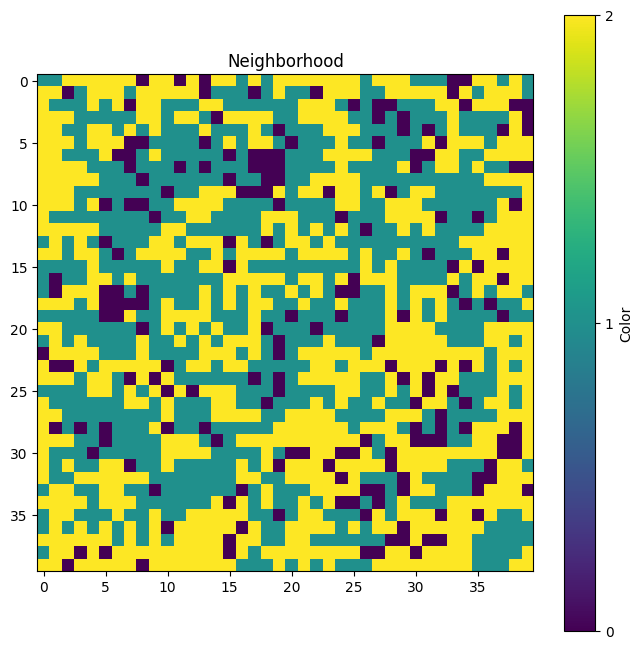

None

[68.8125, 84.625, 86.9375, 88.375, 89.6875, 89.5, 90.0, 90.375, 90.375, 90.3125, 90.25, 90.8125, 90.375, 90.5, 90.5, 90.3125, 90.375, 90.3125, 90.625, 90.3125]


In [134]:
#MAIN BLOCK OF CODE TO RUN SIMULATION
%matplotlib inline

#collecting a list of all empty spaces
empty_coords = collect_empty_spaces(matrix)

#creating array for happiness percentage
happiness = [n for n in range(N)]

#create friend arry if using social network policy
if (relocPolicy == "socialNetwork"):
  friend_list = calculate_friends(df)

for epoch in range(N):

  #getting random order of coordinates to update agents for this particular epoch
  epoch_coords = np.array([(i, j) for i in range(L) for j in range(L)])
  np.random.shuffle(epoch_coords)

  #getting the % of happines at the start of the epoch
  happiness[epoch] = percent_happy(df)

  #printing matrix at the start of the epoch
  print_matrix(df)

  #checking every agent in this epoch
  for coordinate in epoch_coords:

    #storing the current color of agent
    current_color = df[coordinate[0]][coordinate[1]]

    #if the color is empty there is no agent here
    if(current_color == "empty"):
      continue

    #if the agent is happy there is no need to move
    if (is_happy(df, coordinate,df[coordinate[0]][coordinate[1]])):
      continue

    #according to the chosen relocation policy, move the agent
    if(relocPolicy == "random"):
      df = random_move(df, empty_coords, coordinate)
    elif(relocPolicy == "socialNetwork"):
      df = friend_move(df, friend_list, coordinate, empty_coords)
    elif(relocPolicy == "custom1"):
      df = custom1_move(df, coordinate)
    elif(relocPolicy == "custom2"):
      df = custom2_move(df)
    elif(relocPolicy == "custom3"):
      df = custom3_move(df)
    elif(relocPolicy == "custom4"):
      df = custom4_move(df)

  #printing matrix after all agents move for the epoch
  print_matrix(df)

print(happiness)